In [1]:
# Characterize germline insertions

In [74]:
from collections import (
    defaultdict,
    namedtuple,
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools
import seaborn as sns


PAIRS = {
    'KD-6-tumor': 'KD-6-head',
    'KD-8-tumor': 'KD-8-head',
    'BD-09-tumor': 'BD-9-head',
    'BD-10-tumor': 'BD-10-head'
}
PAIRS.update({v:k for k,v in PAIRS.items()})


COLUMNS = ['chrom', 'program', 'insertion', 'start', 'end', 'score', 'strand', 'idk', 'attributes']
insertion = namedtuple('Insertion', COLUMNS)

In [75]:
# PUTATIVE_INSERTIONS = '../../pre-processed-data/raw_insertion_calls/all_putative_germline_insertions.gff3'
PUTATIVE_INSERTIONS = 'putative_delta_germline.gff3'

# COVERAGE_FILE = '../../pre-processed-data/raw_insertion_calls/coverage_over_germline_insertions.tsv'
COVERAGE_FILE = 'delta_coverage_germline.tsv'
ALL_INSERTIONS = 'all_delta_insertions.gff3'
# ALL_INSERTIONS = PUTATIVE_INSERTIONS
SOMATIC_DATA = ['../../pre-processed-data/insertion_calls/0.5.21.filtered_calls_delta_guts.gff', '../../pre-processed-data/insertion_calls/0.5.21.filtered_calls_delta_heads.gff']
INSERTION_SUMMARY = 'Delta All germline TSD insertions.tsv'
FINAL_TABLE = 'Delta Final germline table.tsv'

In [76]:
summary = namedtuple('summary', 'chrom start mate_support split_support nref vaf')


def read_insertions(path):
    all_inserts = defaultdict(list)
    with open(path) as in_fh:
        for line in in_fh:
            fields = line.split()
            chrom = fields[0]
            start = int(fields[3])
            attributes = dict(item.split("=") for item in fields[8].split(";"))
            mate_support = int(attributes['left_mate_count']) + int(attributes['right_mate_count'])
            total_support = int(attributes['total_left_count']) + int(attributes['total_right_count'])
            split_support = total_support - mate_support
            nref = int(attributes['nref'])
            vaf = total_support / (total_support + nref)
            all_inserts[attributes['ID']].append((summary(chrom, start, mate_support, split_support, nref, vaf)))
    return all_inserts

all_inserts = read_insertions(ALL_INSERTIONS)

In [77]:
def find_overlap_support(all_inserts, cluster_id, chrom, start):
    for insert in all_inserts[cluster_id]:
        if insert.chrom == chrom and abs(insert.start - int(start)) < 500:
            return insert.mate_support, insert.split_support
    return 0, 0

def find_nref(all_inserts, cluster_id, chrom, start):
    # nref = []
    for insert in all_inserts[cluster_id]:
        if insert.chrom == chrom and abs(insert.start - int(start)) < 500:
            return insert.nref
    return 0

def find_vaf(all_inserts, cluster_id, chrom, start):
    # vaf = []
    for insert in all_inserts[cluster_id]:
        if insert.chrom == chrom and abs(insert.start - int(start)) < 500:
            return insert.vaf
    return 0

In [78]:
def summarize_overlaps(insertions):
    overlaps = set()
    cluster_ids = set()
    if not insertions:
        raise Exception('nope')
    for index, ins in enumerate(insertions):
        overlaps.add(ins.attributes['ID'].split('_')[0])
        cluster_ids.add(ins.attributes['ID'])
        for overlap in ins.attributes['overlaps'].split(','):
            if overlap:
                cluster_ids.add(overlap)
                overlaps.add(overlap.split('_')[0])
        is_somatic  = (ins.chrom, ins.start, ins.end, ins.insertion) in somatic
    return [index, ins.chrom, ins.start, ins.end, ins.insertion, ins.strand, is_somatic, len(overlaps), cluster_ids]


def get_insertions_by_coordinate(path):
    insertions_by_coordinate = defaultdict(list)
    with open(path) as fh:
        for line in fh:
            fields = line.strip().split('\t')
            fields[8] = dict(item.split("=") for item in fields[8].split(";"))
            ins = insertion(*fields)
            if ins.attributes['valid_TSD'] == 'True':
                insertions_by_coordinate[(ins.chrom, ins.start, ins.end, ins.insertion)].append(ins)
    return insertions_by_coordinate


insertions_by_coordinate = get_insertions_by_coordinate(PUTATIVE_INSERTIONS)


somatic = defaultdict(list)
for dataset in SOMATIC_DATA:
    somatic.update(get_insertions_by_coordinate(dataset))

somatic = {ins: summarize_overlaps(somatic[ins]) for ins in somatic}

In [79]:
len(insertions_by_coordinate)

3521

In [80]:
possible_somatic = {k:v for k, v in insertions_by_coordinate.items() if sum(1 for _ in v if _.attributes['overlaps'].count(',') == 0) == len(v)}

In [81]:
len(possible_somatic)

799

In [82]:
possible_private = defaultdict(list)

for insertions in insertions_by_coordinate.values():
    for record in insertions:
        overlaps = [overlap.split('_')[0] for overlap in record.attributes['overlaps'].split(',')]
        if len(overlaps) == 2 and PAIRS[overlaps[0]] == overlaps[1] and record.attributes['valid_TSD'] == 'True':
            possible_private[(record.chrom, record.start, record.end, record.insertion)].append(record)

In [83]:
early_somatic = {k:v for k,v in possible_private.items() if len(v) == 1}

In [84]:
private = {k:v for k,v in possible_private.items() if len(v) == 2}

In [85]:
def merge_connected_clusters(shared_summary):
    new_summary = []
    n_insertions = len(shared_summary)
    skip = -1
    for i, s in enumerate(shared_summary):
        if not skip == i:
            if i < (n_insertions - 1):
                n_s = shared_summary[i + 1]
                if s[-1] & n_s[-1]:
                    s[-1] = s[-1].union(n_s[-1])
                    skip = i + 1
            s[-2] = len(set(overlap.split('_')[0] for overlap in s[-1]))
            new_summary.append(s)
    return new_summary

<AxesSubplot:xlabel='Number of samples with insertion', ylabel='Number of insertion'>

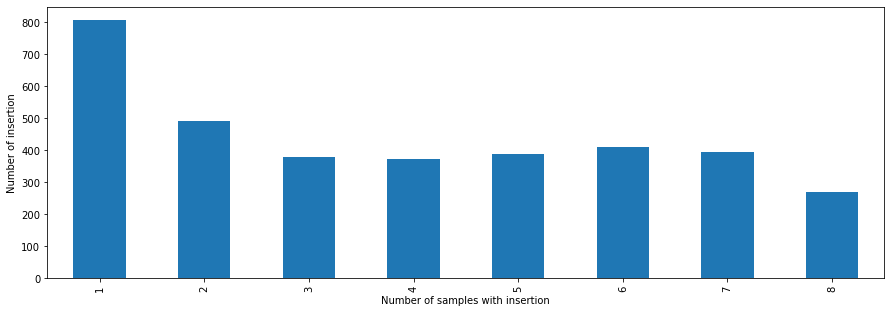

In [86]:
shared_germline = set(insertions_by_coordinate.keys()) - set(possible_somatic.keys()) - set(private.keys())
shared_summary = [summarize_overlaps(insertions_by_coordinate[ins]) for ins in insertions_by_coordinate]

# Make that a recursive call
new_summary = merge_connected_clusters(shared_summary)
new_summary = merge_connected_clusters(list(reversed(new_summary)))
new_summary = merge_connected_clusters(new_summary)
new_summary = list(reversed(merge_connected_clusters(list(reversed(new_summary)))))

shared_df = pd.DataFrame.from_records(shared_summary)
shared_df.columns = ['index', 'chrom', 'start', 'end', 'insertion', 'strand', 'somatic', 'N_samples', 'overlaps',]
shared_df['support'] = shared_df.apply(lambda row: [find_overlap_support(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df['nref'] = shared_df.apply(lambda row: [find_nref(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df['vaf'] = shared_df.apply(lambda row: [find_vaf(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df.N_samples.value_counts().sort_index().plot(kind='bar', figsize=(15, 5), ylabel="Number of insertion", xlabel="Number of samples with insertion")

<AxesSubplot:xlabel='Number of samples with insertion, merge aggressively', ylabel='Number of insertion'>

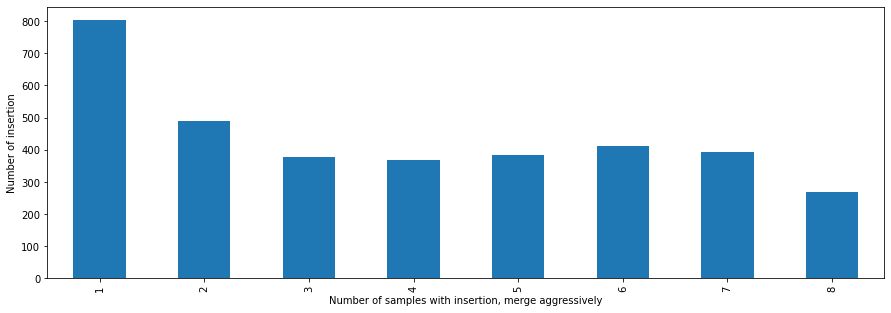

In [87]:
shared_df = pd.DataFrame.from_records(new_summary)
shared_df.columns = ['index', 'chrom', 'start', 'end', 'insertion', 'strand', 'somatic', 'N_samples', 'overlaps']
shared_df['support'] = shared_df.apply(lambda row: [find_overlap_support(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df['nref'] = shared_df.apply(lambda row: [find_nref(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df['vaf'] = shared_df.apply(lambda row: [find_vaf(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
# shared_df = shared_df[shared_df.somatic == False]
shared_df.N_samples.value_counts().sort_index().plot(kind='bar', figsize=(15, 5), ylabel="Number of insertion", xlabel="Number of samples with insertion, merge aggressively")

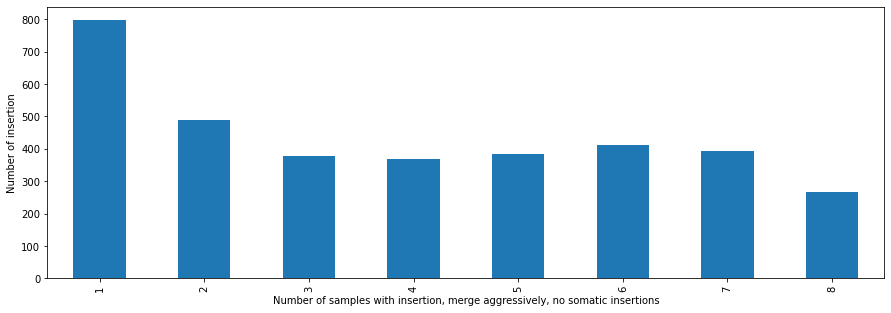

In [88]:
shared_df.somatic = shared_df.apply(lambda row: (row.chrom, row.start, row.end, row.insertion) in somatic, axis=1)
shared_df['private'] = shared_df.apply(lambda row: (row.chrom, row.start, row.end, row.insertion) in possible_private, axis=1)
shared_df.somatic.value_counts()
no_somatic = shared_df[shared_df.somatic == False]
if not no_somatic.empty:
    no_somatic.N_samples.value_counts().sort_index().plot(kind='bar', figsize=(15, 5), ylabel="Number of insertion", xlabel="Number of samples with insertion, merge aggressively, no somatic insertions")

In [89]:
shared_df[(shared_df.somatic == False) & (shared_df.N_samples == 1)]

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,nref,vaf,private
0,0,Y,3632209,3632212,Stalker3,+,False,1,{KD-6-tumor_414},"[(34, 21)]",[1],[0.9821428571428571],False
2,0,Y,3281368,3281369,Stalker4,+,False,1,{KD-6-tumor_210},"[(8, 2)]",[3],[0.7692307692307693],False
3,0,Y,3019692,3019702,TART-B,+,False,1,{KD-6-tumor_28},"[(7, 19)]",[76],[0.2549019607843137],False
4,0,Y,3017562,3017590,1360,+,False,1,{KD-6-tumor_23},"[(6, 1)]",[8],[0.4666666666666667],False
5,0,Y,2967540,2967583,HeT-A,+,False,1,{KD-6-tumor_316},"[(9, 5)]",[19],[0.42424242424242425],False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3419,0,2L,12286359,12286361,G2,+,False,1,{BD-10-head_20},"[(2, 27)]",[48],[0.37662337662337664],False
3428,0,2L,11317637,11317671,Tabor,+,False,1,{BD-10-head_17},"[(35, 20)]",[12],[0.8208955223880597],False
3450,0,2L,9167381,9167392,mdg1,+,False,1,{BD-10-head_6},"[(13, 38)]",[35],[0.5930232558139535],False
3478,0,2L,5044168,5044170,S-element,+,False,1,{BD-10-head_1},"[(8, 16)]",[26],[0.48],False


In [90]:
shared_df.strand.value_counts()

+    3501
Name: strand, dtype: int64

In [91]:
shared_df[(shared_df.somatic == False) & (shared_df.private == True)].insertion.value_counts()

roo               15
BS                10
opus               9
Tabor              9
F-element          7
hobo               6
1360               5
mdg1               5
jockey             5
297                5
Juan               4
Transpac           4
FB                 3
flea               3
copia              3
Rt1a               3
accord2            3
Doc                3
Rt1b               3
Ivk                3
Idefix             3
springer           2
Stalker2           2
Cr1a               2
gypsy12            2
3S18               2
pogo               2
S-element          2
HeT-A              2
R1A1-element       2
Doc2-element       1
invader2           1
412                1
gypsy8             1
1731               1
aurora-element     1
Porto1             1
Stalker            1
Doc3-element       1
Max-element        1
X-element          1
baggins            1
HMS-Beagle2        1
Bari2              1
HMS-Beagle         1
I-element          1
gypsy5             1
Xanthias     

In [92]:
shared_df[(shared_df.somatic == False) & (shared_df.insertion == 'rover')].N_samples.value_counts()

6    3
1    3
8    1
7    1
5    1
3    1
2    1
Name: N_samples, dtype: int64

In [93]:
shared_df[(shared_df.somatic == False) & (shared_df.insertion == 'rover') & (shared_df.N_samples == 68)]

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,nref,vaf,private


In [94]:
shared_df

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,nref,vaf,private
0,0,Y,3632209,3632212,Stalker3,+,False,1,{KD-6-tumor_414},"[(34, 21)]",[1],[0.9821428571428571],False
1,0,Y,3618885,3618888,HeT-A,+,False,2,"{BD-10-tumor_403, KD-6-tumor_409}","[(4, 3), (9, 1)]","[3, 6]","[0.7, 0.625]",False
2,0,Y,3281368,3281369,Stalker4,+,False,1,{KD-6-tumor_210},"[(8, 2)]",[3],[0.7692307692307693],False
3,0,Y,3019692,3019702,TART-B,+,False,1,{KD-6-tumor_28},"[(7, 19)]",[76],[0.2549019607843137],False
4,0,Y,3017562,3017590,1360,+,False,1,{KD-6-tumor_23},"[(6, 1)]",[8],[0.4666666666666667],False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3496,6,2L,1340063,1340075,I-element,+,False,7,"{BD-09-tumor_17, KD-8-tumor_18, KD-6-head_13, ...","[(10, 37), (13, 35), (19, 38), (8, 35), (10, 3...","[31, 47, 42, 26, 38, 13, 14]","[0.6025641025641025, 0.5052631578947369, 0.575...",False
3497,5,2L,1241441,1241448,hobo,+,False,6,"{BD-10-tumor_23, KD-8-tumor_11, BD-09-tumor_15...","[(37, 52), (54, 53), (41, 48), (55, 43), (17, ...","[42, 55, 72, 59, 36, 64]","[0.6793893129770993, 0.6604938271604939, 0.552...",False
3498,6,2L,1074794,1074804,FB,+,False,7,"{KD-8-head_3, BD-09-tumor_8, BD-10-head_5, KD-...","[(18, 30), (32, 42), (26, 53), (31, 66), (26, ...","[30, 39, 34, 43, 38, 35, 19]","[0.6153846153846154, 0.6548672566371682, 0.699...",False
3499,3,2L,629346,629349,Stalker2,+,False,4,"{BD-09-tumor_27, BD-10-head_39, BD-9-head_21, ...","[(9, 38), (23, 48), (9, 28), (5, 23)]","[51, 44, 30, 47]","[0.47959183673469385, 0.6173913043478261, 0.55...",False


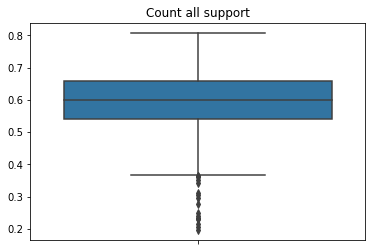

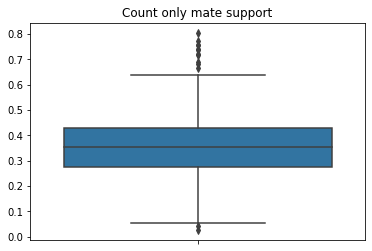

In [95]:
fully_penetrant = shared_df[shared_df.N_samples == 8]
x = fully_penetrant[['chrom', 'start', 'end', 'insertion']]
y = [insertions_by_coordinate[tuple(r)] for r in x.to_records(index=False)]

if not fully_penetrant.empty:
    # All support
    ratio = []
    x_insertions = []
    plt.figure()
    for insertions in y[50:]:
        for ins in insertions:
            if ins.attributes['genotype'] == 'heterozygous' and int(ins.score) > 15:
                if ins.chrom == 'X':
                    x_insertions.append(ins)
                    continue
                nref = int(ins.attributes['nref'])
                score = int(ins.score)
                ratio.append(score /  (score + nref))
    sns.boxplot(pd.Series(ratio), orient='v').set_title("Count all support")
    (np.percentile(ratio, q=1), np.percentile(ratio, q=99))
    # Mate support
    ratio = []
    plt.figure()
    for insertions in y[50:]:
        for ins in insertions:
            if ins.chrom == 'X':
                continue
            if ins.attributes['genotype'] == 'heterozygous' and int(ins.score) > 15:
                nref = int(ins.attributes['nref'])
                score = int(ins.attributes['left_mate_count']) + int(ins.attributes['right_mate_count'])
                ratio.append(score /  (score + nref))
    sns.boxplot(pd.Series(ratio), orient='v').set_title("Count only mate support")
    (np.percentile(ratio, q=1), np.percentile(ratio, q=99))

In [96]:
shared_df

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,nref,vaf,private
0,0,Y,3632209,3632212,Stalker3,+,False,1,{KD-6-tumor_414},"[(34, 21)]",[1],[0.9821428571428571],False
1,0,Y,3618885,3618888,HeT-A,+,False,2,"{BD-10-tumor_403, KD-6-tumor_409}","[(4, 3), (9, 1)]","[3, 6]","[0.7, 0.625]",False
2,0,Y,3281368,3281369,Stalker4,+,False,1,{KD-6-tumor_210},"[(8, 2)]",[3],[0.7692307692307693],False
3,0,Y,3019692,3019702,TART-B,+,False,1,{KD-6-tumor_28},"[(7, 19)]",[76],[0.2549019607843137],False
4,0,Y,3017562,3017590,1360,+,False,1,{KD-6-tumor_23},"[(6, 1)]",[8],[0.4666666666666667],False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3496,6,2L,1340063,1340075,I-element,+,False,7,"{BD-09-tumor_17, KD-8-tumor_18, KD-6-head_13, ...","[(10, 37), (13, 35), (19, 38), (8, 35), (10, 3...","[31, 47, 42, 26, 38, 13, 14]","[0.6025641025641025, 0.5052631578947369, 0.575...",False
3497,5,2L,1241441,1241448,hobo,+,False,6,"{BD-10-tumor_23, KD-8-tumor_11, BD-09-tumor_15...","[(37, 52), (54, 53), (41, 48), (55, 43), (17, ...","[42, 55, 72, 59, 36, 64]","[0.6793893129770993, 0.6604938271604939, 0.552...",False
3498,6,2L,1074794,1074804,FB,+,False,7,"{KD-8-head_3, BD-09-tumor_8, BD-10-head_5, KD-...","[(18, 30), (32, 42), (26, 53), (31, 66), (26, ...","[30, 39, 34, 43, 38, 35, 19]","[0.6153846153846154, 0.6548672566371682, 0.699...",False
3499,3,2L,629346,629349,Stalker2,+,False,4,"{BD-09-tumor_27, BD-10-head_39, BD-9-head_21, ...","[(9, 38), (23, 48), (9, 28), (5, 23)]","[51, 44, 30, 47]","[0.47959183673469385, 0.6173913043478261, 0.55...",False


In [97]:
shared_df.somatic.value_counts()

False    3494
True        7
Name: somatic, dtype: int64

In [98]:
shared_df.N_samples.value_counts()

1    805
2    491
6    411
7    394
5    384
3    379
4    369
8    268
Name: N_samples, dtype: int64

In [99]:
shared_df[(shared_df.somatic == True) & (shared_df.N_samples > 1)]

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,nref,vaf,private
755,0,Y,50331,50347,mdg1,+,True,2,"{BD-10-tumor_34, KD-8-tumor_25}","[(2, 10), (3, 5)]","[29, 14]","[0.2926829268292683, 0.36363636363636365]",False


In [100]:
pretty_summary = shared_df[['chrom', 'start', 'end', 'insertion', 'somatic', 'private', 'N_samples', 'overlaps']]

In [101]:
pretty_summary.to_csv(INSERTION_SUMMARY, sep='\t', index=None)

In [102]:
pretty_summary

,chrom,start,end,insertion,somatic,private,N_samples,overlaps
0,Y,3632209,3632212,Stalker3,False,False,1,{KD-6-tumor_414}
1,Y,3618885,3618888,HeT-A,False,False,2,"{BD-10-tumor_403, KD-6-tumor_409}"
2,Y,3281368,3281369,Stalker4,False,False,1,{KD-6-tumor_210}
3,Y,3019692,3019702,TART-B,False,False,1,{KD-6-tumor_28}
4,Y,3017562,3017590,1360,False,False,1,{KD-6-tumor_23}
...,...,...,...,...,...,...,...,...
3496,2L,1340063,1340075,I-element,False,False,7,"{BD-09-tumor_17, KD-8-tumor_18, KD-6-head_13, ..."
3497,2L,1241441,1241448,hobo,False,False,6,"{BD-10-tumor_23, KD-8-tumor_11, BD-09-tumor_15..."
3498,2L,1074794,1074804,FB,False,False,7,"{KD-8-head_3, BD-09-tumor_8, BD-10-head_5, KD-..."
3499,2L,629346,629349,Stalker2,False,False,4,"{BD-09-tumor_27, BD-10-head_39, BD-9-head_21, ..."


In [103]:
coverage = pd.read_csv(COVERAGE_FILE, sep='\t')

final_table = pd.concat([shared_df, coverage], axis=1)
final_table['median_coverage'] = final_table.iloc[:, 10:].median(axis=1)


def high_and_low_support(list_of_tuples):
    support_one = sum(list_of_tuples[0])
    if len(list_of_tuples) == 1:
        return False
    support_two = sum(list_of_tuples[1])
    if min(support_one, support_two) < 3 and max(support_one, support_two) > 10:
        return True
    return False


final_table['early_developmental'] = (final_table['somatic'] == False) & (final_table['private'] == True) & (final_table['support'].apply(high_and_low_support))

In [104]:
final_table

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,...,BD-10-head,BD-9-head,KD-8-head,KD-6-head,BD-10-tumor,BD-09-tumor,KD-8-tumor,KD-6-tumor,median_coverage,early_developmental
0,0,Y,3632209,3632212,Stalker3,+,False,1,{KD-6-tumor_414},"[(34, 21)]",...,13,4,24,17,9,7,14,31,13.0,False
1,0,Y,3618885,3618888,HeT-A,+,False,2,"{BD-10-tumor_403, KD-6-tumor_409}","[(4, 3), (9, 1)]",...,71,28,49,56,72,85,57,62,57.0,False
2,0,Y,3281368,3281369,Stalker4,+,False,1,{KD-6-tumor_210},"[(8, 2)]",...,17,11,56,42,12,28,63,61,28.0,False
3,0,Y,3019692,3019702,TART-B,+,False,1,{KD-6-tumor_28},"[(7, 19)]",...,64,43,68,72,79,68,82,85,68.0,False
4,0,Y,3017562,3017590,1360,+,False,1,{KD-6-tumor_23},"[(6, 1)]",...,64,43,68,72,79,68,82,85,68.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3496,6,2L,1340063,1340075,I-element,+,False,7,"{BD-09-tumor_17, KD-8-tumor_18, KD-6-head_13, ...","[(10, 37), (13, 35), (19, 38), (8, 35), (10, 3...",...,18,8,21,22,13,11,21,14,14.0,False
3497,5,2L,1241441,1241448,hobo,+,False,6,"{BD-10-tumor_23, KD-8-tumor_11, BD-09-tumor_15...","[(37, 52), (54, 53), (41, 48), (55, 43), (17, ...",...,20,18,26,25,25,21,8,26,21.0,False
3498,6,2L,1074794,1074804,FB,+,False,7,"{KD-8-head_3, BD-09-tumor_8, BD-10-head_5, KD-...","[(18, 30), (32, 42), (26, 53), (31, 66), (26, ...",...,20,18,26,25,25,21,8,26,21.0,False
3499,3,2L,629346,629349,Stalker2,+,False,4,"{BD-09-tumor_27, BD-10-head_39, BD-9-head_21, ...","[(9, 38), (23, 48), (9, 28), (5, 23)]",...,20,18,26,25,25,21,8,26,21.0,False


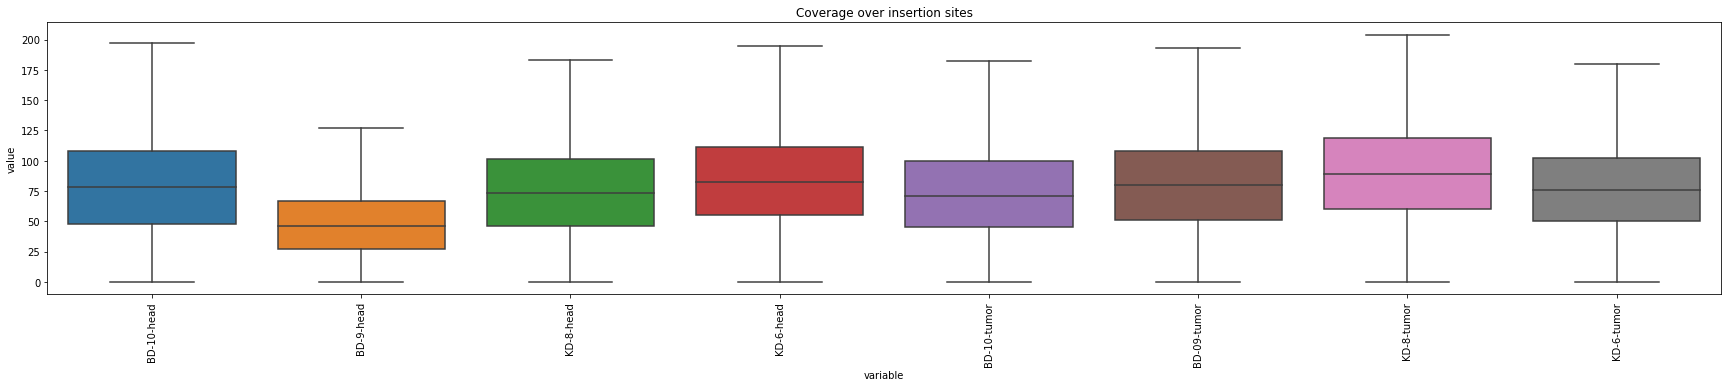

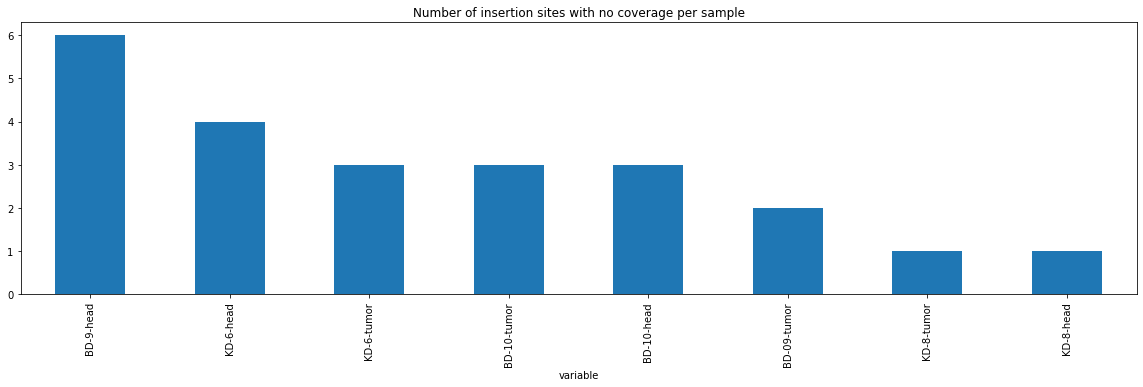

In [106]:
def plot_coverage_data(coverage_data):
    # Coverage over insertion sites
    fig, ax = plt.subplots(figsize=(30, 5))
    sns.boxplot(x='variable', y='value', showfliers = False, data=coverage_data, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_title('Coverage over insertion sites')
    
    # Insertion sites without coverage
    fig, ax = plt.subplots(figsize=(30, 5))
    germline_sites_without_coverage = coverage_data['value'].eq(0).astype(int).groupby(coverage_data['variable']).sum().sort_values(ascending=False)
    germline_sites_without_coverage.plot(kind='bar', x='sample', y='count', figsize=(20, 5), title='Number of insertion sites with no coverage per sample', ax=ax)

coverage_data = final_table.iloc[:, 13:-2].melt()
plot_coverage_data(coverage_data)

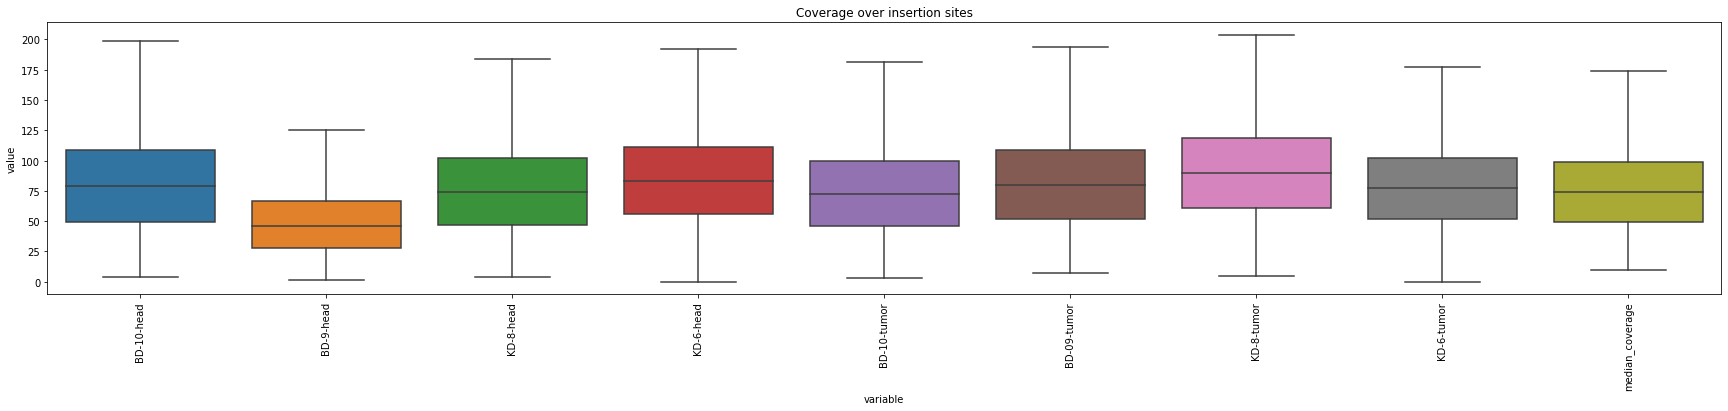

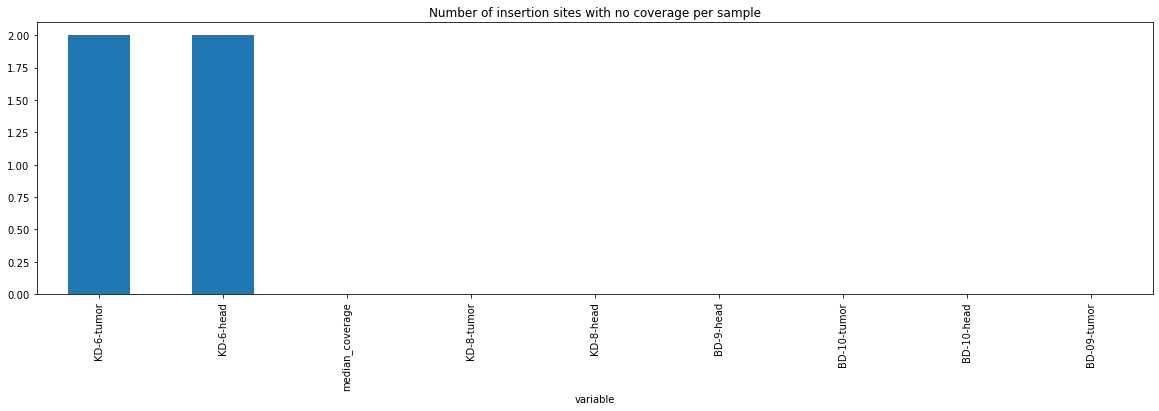

In [107]:
coverage_data = final_table[final_table.median_coverage >= 10].iloc[:, 13:-1].melt()
plot_coverage_data(coverage_data)

In [108]:
final_table

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,...,BD-10-head,BD-9-head,KD-8-head,KD-6-head,BD-10-tumor,BD-09-tumor,KD-8-tumor,KD-6-tumor,median_coverage,early_developmental
0,0,Y,3632209,3632212,Stalker3,+,False,1,{KD-6-tumor_414},"[(34, 21)]",...,13,4,24,17,9,7,14,31,13.0,False
1,0,Y,3618885,3618888,HeT-A,+,False,2,"{BD-10-tumor_403, KD-6-tumor_409}","[(4, 3), (9, 1)]",...,71,28,49,56,72,85,57,62,57.0,False
2,0,Y,3281368,3281369,Stalker4,+,False,1,{KD-6-tumor_210},"[(8, 2)]",...,17,11,56,42,12,28,63,61,28.0,False
3,0,Y,3019692,3019702,TART-B,+,False,1,{KD-6-tumor_28},"[(7, 19)]",...,64,43,68,72,79,68,82,85,68.0,False
4,0,Y,3017562,3017590,1360,+,False,1,{KD-6-tumor_23},"[(6, 1)]",...,64,43,68,72,79,68,82,85,68.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3496,6,2L,1340063,1340075,I-element,+,False,7,"{BD-09-tumor_17, KD-8-tumor_18, KD-6-head_13, ...","[(10, 37), (13, 35), (19, 38), (8, 35), (10, 3...",...,18,8,21,22,13,11,21,14,14.0,False
3497,5,2L,1241441,1241448,hobo,+,False,6,"{BD-10-tumor_23, KD-8-tumor_11, BD-09-tumor_15...","[(37, 52), (54, 53), (41, 48), (55, 43), (17, ...",...,20,18,26,25,25,21,8,26,21.0,False
3498,6,2L,1074794,1074804,FB,+,False,7,"{KD-8-head_3, BD-09-tumor_8, BD-10-head_5, KD-...","[(18, 30), (32, 42), (26, 53), (31, 66), (26, ...",...,20,18,26,25,25,21,8,26,21.0,False
3499,3,2L,629346,629349,Stalker2,+,False,4,"{BD-09-tumor_27, BD-10-head_39, BD-9-head_21, ...","[(9, 38), (23, 48), (9, 28), (5, 23)]",...,20,18,26,25,25,21,8,26,21.0,False


In [109]:

final_table[final_table['early_developmental']]

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,...,BD-10-head,BD-9-head,KD-8-head,KD-6-head,BD-10-tumor,BD-09-tumor,KD-8-tumor,KD-6-tumor,median_coverage,early_developmental
1319,0,2R,1022413,1022425,accord2,+,False,2,"{KD-6-head_41, KD-6-tumor_35}","[(34, 27), (0, 0)]",...,104,63,93,74,101,120,101,89,93.0,True
1699,0,2R,3023774,3023814,X-element,+,False,2,"{KD-8-tumor_27, KD-8-head_21}","[(0, 0), (24, 7)]",...,15,16,21,23,18,35,32,28,21.0,True


Text(0.5, 1.0, 'Germline private TE insertions')

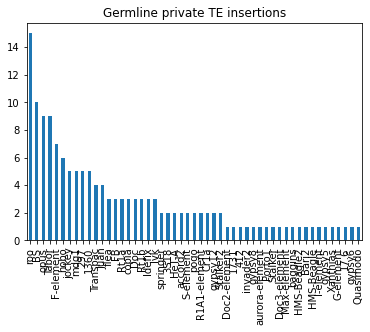

In [110]:
final_table[(~final_table['early_developmental']) & (final_table['private'])].insertion.value_counts().plot(kind='bar').set_title('Germline private TE insertions')

Text(0.5, 1.0, 'Germline private TE insertions')

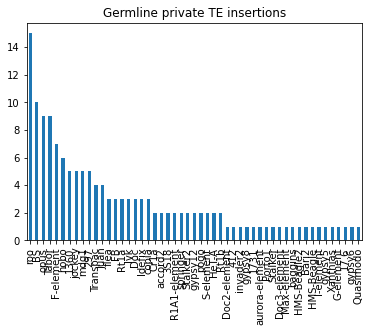

In [111]:
final_table[(final_table['median_coverage'] >=10) & (~final_table['early_developmental']) & (final_table['private'])].insertion.value_counts().plot(kind='bar').set_title('Germline private TE insertions')

In [112]:
final_table[(~final_table['early_developmental']) & (final_table['private']) & (final_table['insertion'] == 'copia')]

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,...,BD-10-head,BD-9-head,KD-8-head,KD-6-head,BD-10-tumor,BD-09-tumor,KD-8-tumor,KD-6-tumor,median_coverage,early_developmental
1337,1,2R,39294,39300,copia,+,False,2,"{KD-6-head_25, KD-6-tumor_26}","[(6, 25), (8, 15)]",...,191,91,189,221,132,168,187,209,187.0,False
1357,1,2L,22085546,22085550,copia,+,False,2,"{KD-6-head_32, KD-6-tumor_53}","[(21, 20), (10, 19)]",...,71,63,83,83,79,96,88,86,83.0,False
2105,1,2L,9042516,9042520,copia,+,False,2,"{BD-09-tumor_1, BD-9-head_0}","[(10, 40), (3, 13)]",...,105,55,110,72,94,74,46,85,74.0,False


In [113]:
final_table[final_table['median_coverage'] < 10]

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,...,BD-10-head,BD-9-head,KD-8-head,KD-6-head,BD-10-tumor,BD-09-tumor,KD-8-tumor,KD-6-tumor,median_coverage,early_developmental
464,0,2R,2169082,2169095,BS,+,False,2,"{BD-9-head_105, KD-8-tumor_188}","[(30, 7), (69, 38)]",...,19,3,4,16,4,8,14,5,5.0,False
470,0,2R,1630933,1630954,Doc,+,False,1,{KD-8-tumor_765},"[(12, 4)]",...,14,9,6,12,5,8,12,10,9.0,False
540,0,X,3104945,3104955,opus,+,False,1,{BD-09-tumor_12},"[(27, 34)]",...,4,1,4,6,9,5,4,5,4.0,False
552,0,3R,25858692,25858699,hobo,+,False,1,{BD-09-tumor_33},"[(20, 32)]",...,10,4,10,3,4,6,6,4,4.0,False
631,0,3L,23360969,23360986,gypsy2,+,False,1,{BD-09-tumor_383},"[(35, 3)]",...,2,0,2,3,2,2,6,5,2.0,False
634,0,3L,23055410,23055425,mdg1,+,False,1,{BD-09-tumor_40},"[(9, 37)]",...,9,5,7,6,4,14,12,9,7.0,False
773,0,X,21585579,21585585,mariner2,+,False,5,"{KD-8-head_111, KD-6-head_110, KD-8-tumor_111,...","[(9, 12), (4, 8), (11, 15), (16, 13), (3, 3)]",...,9,2,4,17,4,7,15,12,7.0,False
774,1,X,20978902,20978917,Tabor,+,False,2,"{KD-6-tumor_129, BD-10-tumor_103}","[(4, 13), (3, 12)]",...,8,2,4,17,4,7,15,12,7.0,False
811,1,4,332515,332515,INE-1,+,False,4,"{BD-10-head_141, BD-10-tumor_178, BD-09-tumor_...","[(3, 32), (6, 65), (3, 49), (6, 42)]",...,5,0,4,9,8,13,14,16,8.0,False
821,0,3R,18333103,18333132,hopper,+,False,5,"{BD-10-tumor_48, KD-6-tumor_68, KD-6-head_23, ...","[(9, 3), (8, 2), (5, 2), (8, 3), (5, 2)]",...,5,0,1,3,1,1,8,8,1.0,False


In [114]:
final_table.to_csv(FINAL_TABLE, sep='\t', index=None)

In [115]:
final_table

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,...,BD-10-head,BD-9-head,KD-8-head,KD-6-head,BD-10-tumor,BD-09-tumor,KD-8-tumor,KD-6-tumor,median_coverage,early_developmental
0,0,Y,3632209,3632212,Stalker3,+,False,1,{KD-6-tumor_414},"[(34, 21)]",...,13,4,24,17,9,7,14,31,13.0,False
1,0,Y,3618885,3618888,HeT-A,+,False,2,"{BD-10-tumor_403, KD-6-tumor_409}","[(4, 3), (9, 1)]",...,71,28,49,56,72,85,57,62,57.0,False
2,0,Y,3281368,3281369,Stalker4,+,False,1,{KD-6-tumor_210},"[(8, 2)]",...,17,11,56,42,12,28,63,61,28.0,False
3,0,Y,3019692,3019702,TART-B,+,False,1,{KD-6-tumor_28},"[(7, 19)]",...,64,43,68,72,79,68,82,85,68.0,False
4,0,Y,3017562,3017590,1360,+,False,1,{KD-6-tumor_23},"[(6, 1)]",...,64,43,68,72,79,68,82,85,68.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3496,6,2L,1340063,1340075,I-element,+,False,7,"{BD-09-tumor_17, KD-8-tumor_18, KD-6-head_13, ...","[(10, 37), (13, 35), (19, 38), (8, 35), (10, 3...",...,18,8,21,22,13,11,21,14,14.0,False
3497,5,2L,1241441,1241448,hobo,+,False,6,"{BD-10-tumor_23, KD-8-tumor_11, BD-09-tumor_15...","[(37, 52), (54, 53), (41, 48), (55, 43), (17, ...",...,20,18,26,25,25,21,8,26,21.0,False
3498,6,2L,1074794,1074804,FB,+,False,7,"{KD-8-head_3, BD-09-tumor_8, BD-10-head_5, KD-...","[(18, 30), (32, 42), (26, 53), (31, 66), (26, ...",...,20,18,26,25,25,21,8,26,21.0,False
3499,3,2L,629346,629349,Stalker2,+,False,4,"{BD-09-tumor_27, BD-10-head_39, BD-9-head_21, ...","[(9, 38), (23, 48), (9, 28), (5, 23)]",...,20,18,26,25,25,21,8,26,21.0,False
